# Import necessary libraries

In [1]:
import torch
import os
import wget
import json
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt 
import xgboost as xgb
import math

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from pytorch_tabnet.tab_model import TabNetRegressor
from pathlib import Path

np.random.seed(0)
sb.set() 
model = TabNetRegressor(device_name='cuda') 


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [2]:
csv_data = pd.read_csv('data/clean_data/final_data.csv')

with open('data/clean_data/encoding_mappings.json', 'r') as fp:
    encoding_mappings = json.load(fp)

final_data = csv_data[csv_data['Year'] >= 2000]
final_data 


,Year,Month,lease_commence_date,floor_area_sqm,average_storey,resale_price_adjusted,town,flat_type,flat_model
0,2000,1,1986,69.0,8.0,219202.861724,1,2,6
1,2000,1,1970,66.0,5.0,216220.509864,6,2,6
2,2000,1,1970,72.0,17.0,310164.593460,6,2,6
3,2000,1,1970,72.0,5.0,277358.722998,6,2,6
4,2000,1,1970,72.0,2.0,271394.019278,6,2,6
...,...,...,...,...,...,...,...,...,...
633997,2024,3,1990,105.0,2.0,538888.000000,12,3,5
633998,2024,3,1985,91.0,11.0,538000.000000,12,3,3
633999,2024,3,1978,98.0,8.0,538000.000000,12,3,3
634000,2024,3,2019,92.0,5.0,573000.000000,12,3,5


In [3]:
for category, mappings in encoding_mappings.items():
    print(f"{category}:")
    for key, value in mappings.items():
        print(f"  {key}: {value}")
    print() 

town:
  GEYLANG: 0
  ANG MO KIO: 1
  YISHUN: 2
  BEDOK: 3
  TOA PAYOH: 4
  BUKIT BATOK: 5
  QUEENSTOWN: 6
  CLEMENTI: 7
  JURONG EAST: 8
  JURONG WEST: 9
  WOODLANDS: 10
  KALLANG/WHAMPOA: 11
  HOUGANG: 12
  BUKIT PANJANG: 13
  SERANGOON: 14
  CHOA CHU KANG: 15
  SEMBAWANG: 16
  CENTRAL AREA: 17
  TAMPINES: 18
  MARINE PARADE: 19
  BUKIT MERAH: 20
  SENGKANG: 21
  PASIR RIS: 22
  PUNGGOL: 23
  BISHAN: 24
  BUKIT TIMAH: 25

flat_type:
  1 ROOM: 0
  2 ROOM: 1
  3 ROOM: 2
  4 ROOM: 3
  5 ROOM: 4
  EXECUTIVE: 5
  MULTI-GENERATION: 6

flat_model:
  Standard: 0
  2-room: 1
  Simplified: 2
  New Generation: 3
  Model A2: 4
  Model A: 5
  Improved: 6
  Premium Apartment: 7
  Adjoined flat: 8
  Apartment: 9
  Model A-Maisonette: 10
  Improved-Maisonette: 11
  Maisonette: 12
  Multi Generation: 13
  3Gen: 14
  Terrace: 15
  Premium Maisonette: 16
  DBSS: 17
  Type S1: 18
  Premium Apartment Loft: 19
  Type S2: 20



In [4]:
def encode_new_input(new_input, encoding_mappings):
# If new_input is a dictionary, convert it to a DataFrame
    if isinstance(new_input, dict):
        new_input = pd.DataFrame([new_input])
    
    # If new_input is a list of dictionaries, convert it to a DataFrame
    elif isinstance(new_input, list):
        new_input = pd.DataFrame(new_input)

    # Ensure that new_input is a DataFrame at this point
    if not isinstance(new_input, pd.DataFrame):
        raise ValueError("new_input must be a pandas DataFrame, a dictionary, or a list of dictionaries.")    
    new_input_encoded = new_input.copy()
    for column, mapping in encoding_mappings.items():
        if column in new_input.columns:
            # Apply the mapping to the column
            new_input_encoded[column] = new_input[column].map(mapping)
            # Fill in NaN values if the category was not seen during training
            if new_input_encoded[column].isna().any():
                unknown_rank = np.median(list(mapping.values()))
                # Use direct assignment instead of inplace=True
                new_input_encoded[column] = new_input_encoded[column].fillna(unknown_rank)
    
    return new_input_encoded

In [5]:
features = ['Year','Month','floor_area_sqm', 'lease_commence_date', 'average_storey','town', 'flat_type', 'flat_model']
target = 'resale_price_adjusted'

# Employing basic linearing regression model with the numerical data

Goodness of Fit on Test Dataset:

Linear Regression Model:
Explained Variance (R^2): 0.7001593205392791
Mean Squared Error (MSE): 8034973341.5547495

XGBoost Model:
Explained Variance (R^2): 0.9568476342909792
Mean Squared Error (MSE): 1156374474.3395467



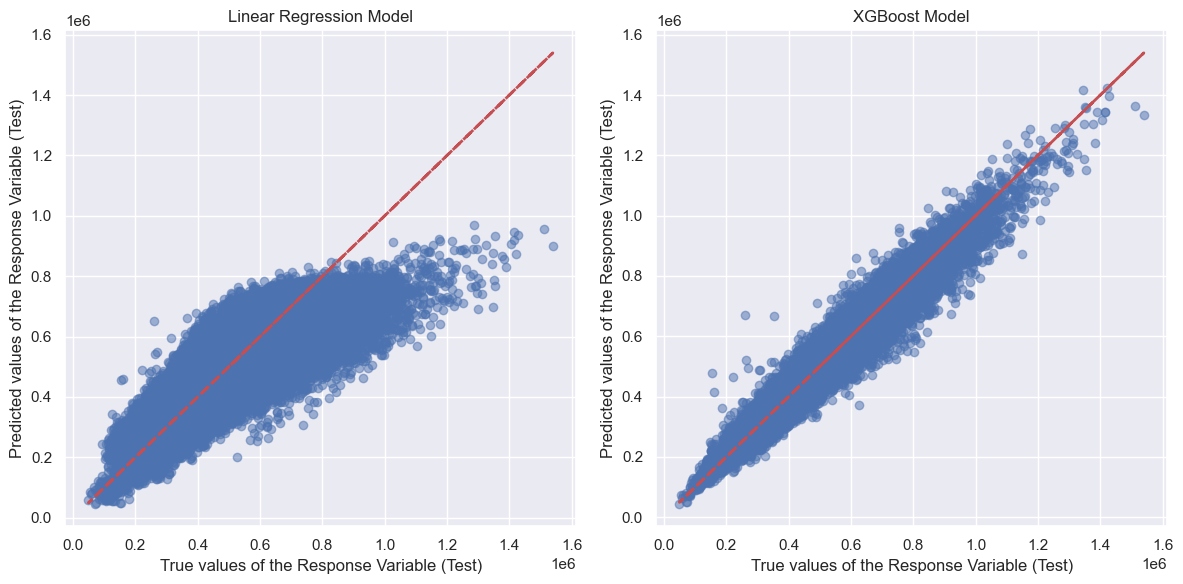

In [6]:
X_train, X_test, y_train, y_test = train_test_split(final_data[features], final_data[target], test_size=0.1, random_state=42)

linreg = LinearRegression()
linreg.fit(X_train, y_train)

xgbreg = xgb.XGBRegressor(
    objective='reg:squarederror', 
    booster='gbtree', 
    reg_alpha=0.1, 
    reg_lambda=0.1)
xgbreg.fit(X_train,y_train)

y_test_pred_linReg = linreg.predict(X_test)
y_test_pred_xgb = xgbreg.predict(X_test)

print("Goodness of Fit on Test Dataset:")
print()
print("Linear Regression Model:")
print("Explained Variance (R^2):", r2_score(y_test, y_test_pred_linReg))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_test_pred_linReg))
print()

print("XGBoost Model:")
print("Explained Variance (R^2):", r2_score(y_test, y_test_pred_xgb))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_test_pred_xgb))
print()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_pred_linReg, alpha= 0.5)
plt.plot(y_test, y_test, 'r--', linewidth=2)
plt.xlabel("True values of the Response Variable (Test)")
plt.ylabel("Predicted values of the Response Variable (Test)")
plt.title("Linear Regression Model")

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred_xgb, alpha= 0.5)
plt.plot(y_test, y_test, 'r--', linewidth=2)
plt.xlabel("True values of the Response Variable (Test)")
plt.ylabel("Predicted values of the Response Variable (Test)")
plt.title("XGBoost Model")

plt.tight_layout()
plt.show()


In [13]:
from scipy import stats
from scipy.special import inv_boxcox

# Apply Box-Cox transformation
y_train_boxcox, lambda_boxcox = stats.boxcox(y_train)
y_test_boxcox = stats.boxcox(y_test, lmbda=lambda_boxcox) 

# Split the transformed y_train for validation purposes
X_train_tabnet, X_valid_tabnet, y_train_tabnet_boxcox, y_valid_tabnet_boxcox = train_test_split(
                                                                                        X_train, 
                                                                                        y_train_boxcox, 
                                                                                        test_size=0.1, random_state=42)

# Convert to numpy values for TabNet
X_train_tabnet_values = X_train_tabnet.values
X_valid_tabnet_values = X_valid_tabnet.values
y_train_tabnet_boxcox_values = y_train_tabnet_boxcox.reshape(-1, 1)
y_valid_tabnet_boxcox_values = y_valid_tabnet_boxcox.reshape(-1, 1)

# Train a linear regression model after Box-Cox transformation
linreg_withBoxCox = LinearRegression()
linreg_withBoxCox.fit(X_train, y_train_boxcox)

# Train a XGBoost model after Box-Cox transformation
xgbreg_withBoxCox = xgb.XGBRegressor(
    objective='reg:squarederror', 
    booster='gbtree', 
    reg_alpha=0.1, 
    reg_lambda=0.1)
xgbreg_withBoxCox.fit(X_train, y_train_boxcox)

y_test_pred_linReg_boxcox = linreg_withBoxCox.predict(X_test)
y_test_pred_xgb_boxcox =  xgbreg_withBoxCox.predict(X_test)
# Inverse transform predictions from the Box-Cox scale to the original scale
y_test_pred_linReg_original_scale = inv_boxcox(y_test_pred_linReg_boxcox, lambda_boxcox)
y_test_pred_xgb_original_scale = inv_boxcox(y_test_pred_xgb_boxcox, lambda_boxcox)

# Evaluate the Linear Regression model on the original scale
print("Linear Regression Model (with Box-Cox transformation):")
print("Explained Variance (R^2):", r2_score(y_test, y_test_pred_linReg_original_scale))
print("Root Mean Squared Error (RMSE):", math.sqrt(mean_squared_error(y_test, y_test_pred_linReg_original_scale)))
print()

# Evaluate the XGBoost model on the original scale
print("XGBoost Model (with Box-Cox transformation):")
print("Explained Variance (R^2):", r2_score(y_test, y_test_pred_xgb_original_scale))
print("Root Mean Squared Error (RMSE):", math.sqrt(mean_squared_error(y_test, y_test_pred_xgb_original_scale)))
print()


Linear Regression Model (with Box-Cox transformation):
Explained Variance (R^2): 0.7003549169166182
Root Mean Squared Error (RMSE): 89608.7710683115

XGBoost Model (with Box-Cox transformation):
Explained Variance (R^2): 0.955981841427905
Root Mean Squared Error (RMSE): 34344.9492299273



In [14]:
# Train a TabNet model after Box-Cox transformation
tabnetReg = TabNetRegressor()
max_epochs = 200

tabnetReg.fit(
    X_train_tabnet_values, 
    y_train_tabnet_boxcox_values,
    eval_set=[(X_train_tabnet_values, y_train_tabnet_boxcox_values), 
              (X_valid_tabnet_values, y_valid_tabnet_boxcox_values)],
    eval_name=['train', 'valid'],
    eval_metric=['mae', 'rmse'],
    max_epochs=max_epochs,
    patience=20,
    batch_size=4096,
    virtual_batch_size=512,
    num_workers=0,
    drop_last=False
)


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 161.77101| train_mae: 13.05819| train_rmse: 15.30564| valid_mae: 13.08313| valid_rmse: 15.33158|  0:00:45s
epoch 1  | loss: 0.82008 | train_mae: 7.82777 | train_rmse: 9.04234 | valid_mae: 7.82912 | valid_rmse: 9.05085 |  0:01:39s
epoch 2  | loss: 0.74836 | train_mae: 4.07415 | train_rmse: 4.4595  | valid_mae: 4.07708 | valid_rmse: 4.46136 |  0:02:32s
epoch 3  | loss: 0.69342 | train_mae: 1.81453 | train_rmse: 2.10833 | valid_mae: 1.81387 | valid_rmse: 2.10707 |  0:03:17s
epoch 4  | loss: 0.67921 | train_mae: 0.74946 | train_rmse: 0.9498  | valid_mae: 0.75297 | valid_rmse: 0.95457 |  0:03:57s
epoch 5  | loss: 0.70318 | train_mae: 0.61102 | train_rmse: 0.79257 | valid_mae: 0.61055 | valid_rmse: 0.79191 |  0:04:34s
epoch 6  | loss: 0.63738 | train_mae: 0.58766 | train_rmse: 0.75987 | valid_mae: 0.58912 | valid_rmse: 0.76142 |  0:05:15s
epoch 7  | loss: 0.58346 | train_mae: 0.53739 | train_rmse: 0.72475 | valid_mae: 0.53751 | valid_rmse: 0.72568 |  0:05:51s
epoch 8  | loss

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


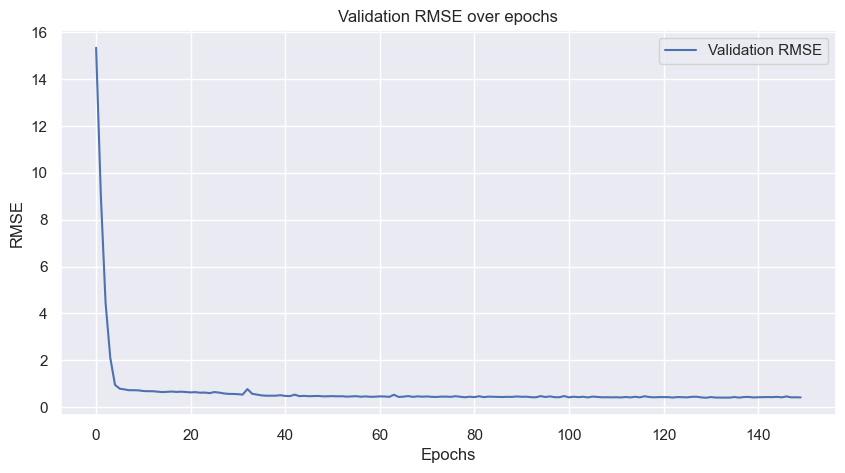

In [15]:
valid_rmse = tabnetReg.history['valid_rmse']

epochs = range(len(valid_rmse))

plt.figure(figsize=(10,5))
plt.plot(epochs, valid_rmse, label='Validation RMSE')
plt.title('Validation RMSE over epochs')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

Goodness of Fit on Test Dataset:

Linear Regression Model:
Explained Variance (R^2): 0.7001593205392791
Root Mean Squared Error (RMSE): 89638.0128157399

XGBoost Model:
Explained Variance (R^2): 0.9568476342909792
Root Mean Squared Error (RMSE): 34005.50652967173

Linear Regression Model (with log transformation):
Explained Variance (R^2): 0.7003549169166182
Root Mean Squared Error (RMSE): 89608.7710683115

XGBoost Model (with log transformation):
Explained Variance (R^2): 0.955981841427905
Root Mean Squared Error (RMSE): 34344.9492299273

Tabnet Model (with log transformation):
Explained Variance (R^2): 0.9449388727898873
Root Mean Squared Error (RMSE): 38412.227507265445



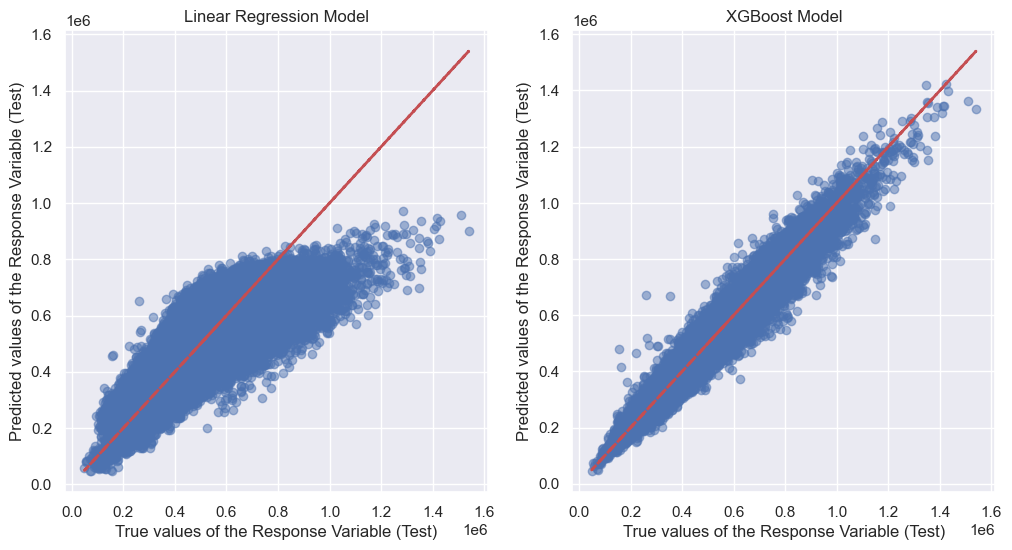

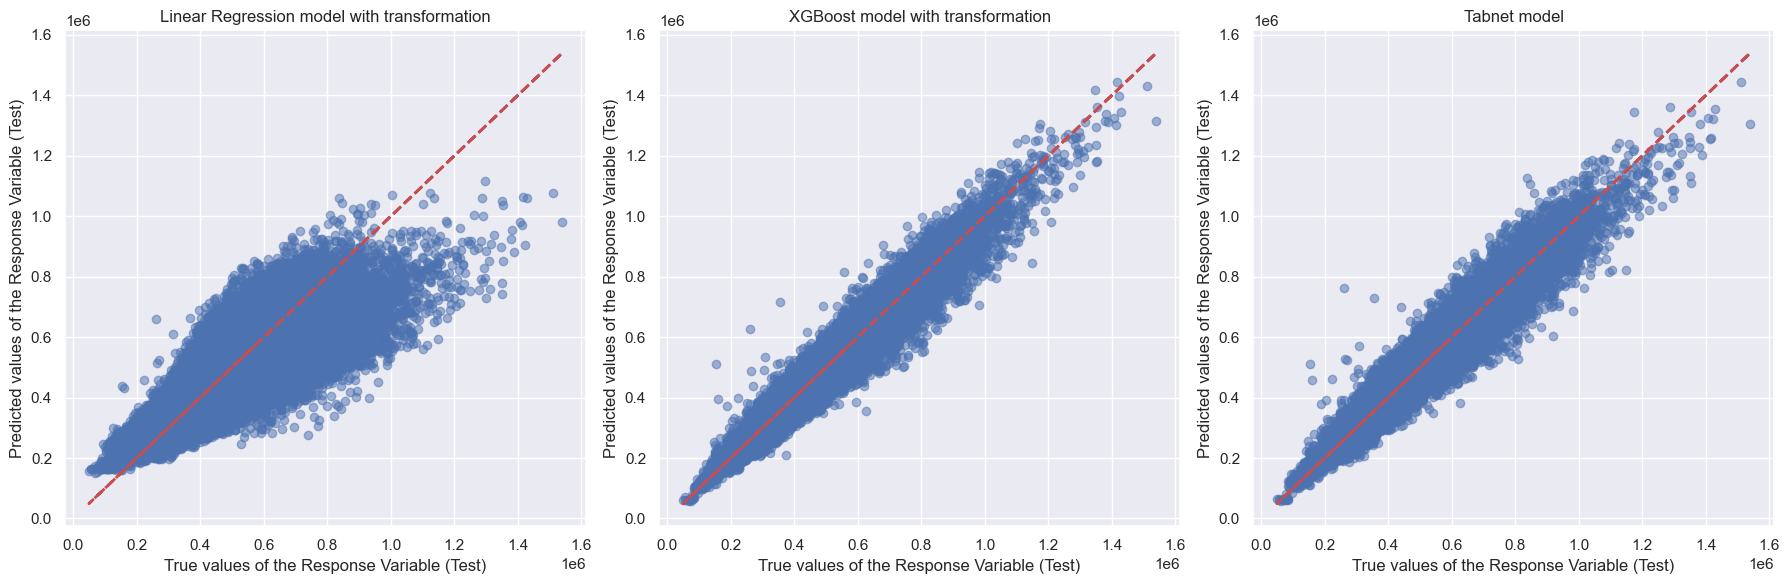

In [25]:
y_test_pred_linReg = linreg.predict(X_test)
y_test_pred_xgb = xgbreg.predict(X_test)
y_test_pred_linReg_boxcox = linreg_withBoxCox.predict(X_test)
y_test_pred_xgb_boxcox =  xgbreg_withBoxCox.predict(X_test)
y_test_pred_tabnet_boxcox = tabnetReg.predict(X_test.values)

y_test_pred_linReg_original_scale = inv_boxcox(y_test_pred_linReg_boxcox, lambda_boxcox)
y_test_pred_xgb_original_scale = inv_boxcox(y_test_pred_xgb_boxcox, lambda_boxcox)
y_test_pred_tabnet_original_scale = inv_boxcox(y_test_pred_tabnet_boxcox, lambda_boxcox)

print("Goodness of Fit on Test Dataset:")
print()
print("Linear Regression Model:")
print("Explained Variance (R^2):", r2_score(y_test, y_test_pred_linReg))
print("Root Mean Squared Error (RMSE):", math.sqrt(mean_squared_error(y_test, y_test_pred_linReg)))
print()

print("XGBoost Model:")
print("Explained Variance (R^2):", r2_score(y_test, y_test_pred_xgb))
print("Root Mean Squared Error (RMSE):", math.sqrt(mean_squared_error(y_test, y_test_pred_xgb)))
print()

print("Linear Regression Model (with log transformation):")
print("Explained Variance (R^2):", r2_score(y_test, y_test_pred_linReg_original_scale))
print("Root Mean Squared Error (RMSE):", math.sqrt(mean_squared_error(y_test, y_test_pred_linReg_original_scale)))
print()

print("XGBoost Model (with log transformation):")
print("Explained Variance (R^2):", r2_score(y_test, y_test_pred_xgb_original_scale))
print("Root Mean Squared Error (RMSE):", math.sqrt(mean_squared_error(y_test, y_test_pred_xgb_original_scale)))
print()


print("Tabnet Model (with log transformation):")
print("Explained Variance (R^2):", r2_score(y_test, y_test_pred_tabnet_original_scale))
print("Root Mean Squared Error (RMSE):", math.sqrt(mean_squared_error(y_test, y_test_pred_tabnet_original_scale)))
print()

# Plot the Predictions versus True values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_pred_linReg, alpha= 0.5)
plt.plot(y_test, y_test, 'r--', linewidth=2)
plt.xlabel("True values of the Response Variable (Test)")
plt.ylabel("Predicted values of the Response Variable (Test)")
plt.title("Linear Regression Model")

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred_xgb, alpha= 0.5)
plt.plot(y_test, y_test, 'r--', linewidth=2)
plt.xlabel("True values of the Response Variable (Test)")
plt.ylabel("Predicted values of the Response Variable (Test)")
plt.title("XGBoost Model")

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.scatter(y_test, y_test_pred_linReg_original_scale, alpha=0.5)
plt.plot(y_test, y_test, 'r--', linewidth=2)
plt.xlabel("True values of the Response Variable (Test)")
plt.ylabel("Predicted values of the Response Variable (Test)")
plt.title("Linear Regression model with transformation")

plt.subplot(1, 3, 2)
plt.scatter(y_test, y_test_pred_xgb_original_scale, alpha=0.5)
plt.plot(y_test, y_test, 'r--', linewidth=2)
plt.xlabel("True values of the Response Variable (Test)")
plt.ylabel("Predicted values of the Response Variable (Test)")
plt.title("XGBoost model with transformation")

plt.subplot(1, 3, 3)
plt.scatter(y_test, y_test_pred_tabnet_original_scale, alpha=0.5)
plt.plot(y_test, y_test, 'r--', linewidth=2)
plt.xlabel("True values of the Response Variable (Test)")
plt.ylabel("Predicted values of the Response Variable (Test)")
plt.title("Tabnet model")
plt.tight_layout()
plt.show()

In [18]:
linear_regression_coefficients = linreg_withBoxCox.coef_
linear_regression_intercept = linreg_withBoxCox.intercept_
linear_regression_withLog_coefficients = linreg_withBoxCox.coef_
linear_regression_withLog_intercept = linreg_withBoxCox.intercept_


xgboost_feature_importances = xgbreg.feature_importances_
xgboost_withLog_feature_importances = xgbreg_withBoxCox.feature_importances_

tabnet_feature_importances = tabnetReg.feature_importances_


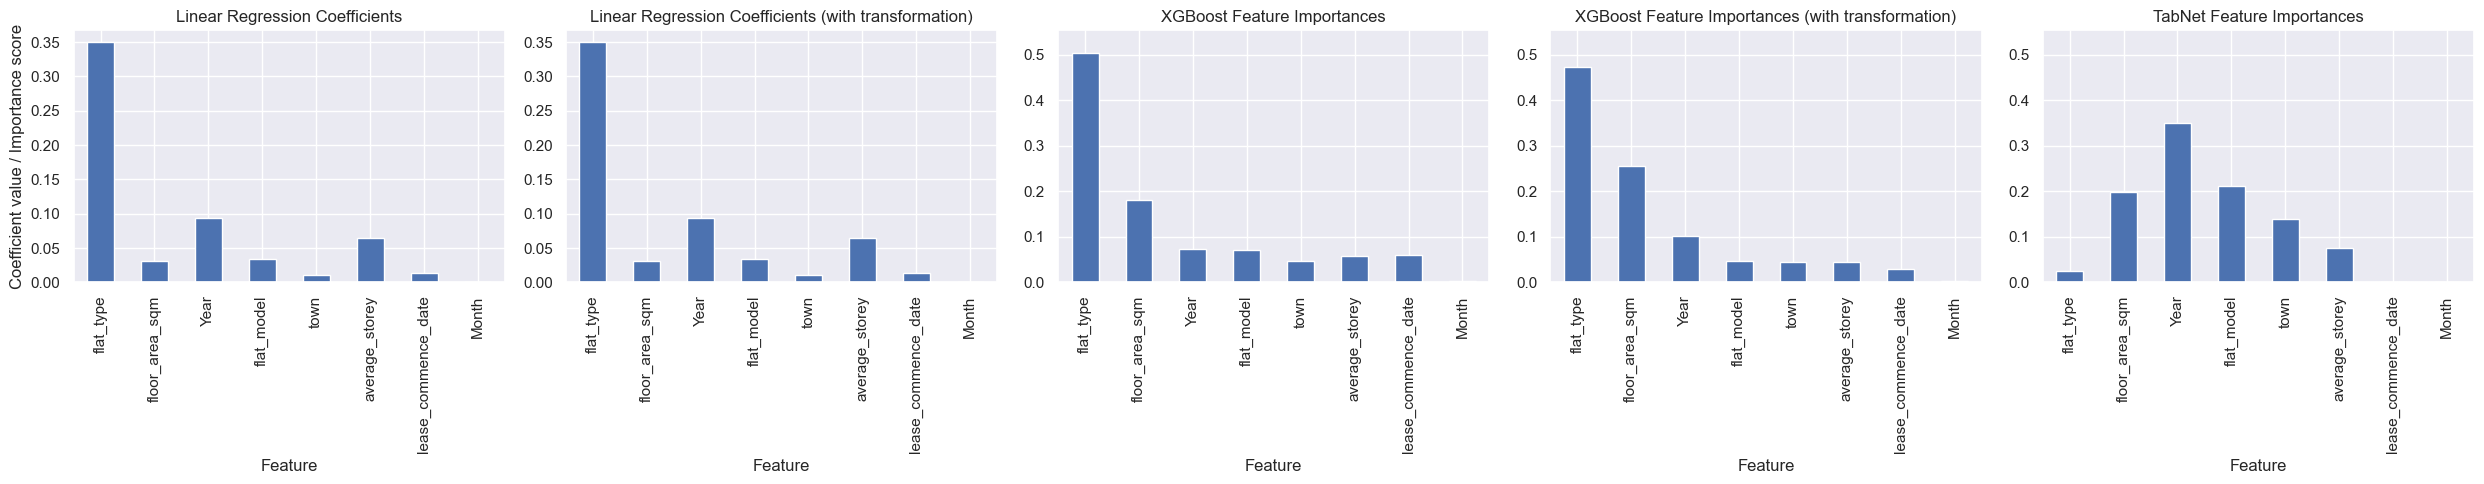

In [19]:
# Create a DataFrame to hold the feature importances
df_feature_importance = pd.DataFrame({
    'Feature': features,
    'Linear Regression': linear_regression_coefficients,
    'Linear Regression (with transformation)': linear_regression_withLog_coefficients,
    'XGBoost': xgboost_feature_importances,
    'XGBoost (with transformation)': xgboost_withLog_feature_importances,
    'TabNet': tabnet_feature_importances
})

df_feature_importance.sort_values(by='XGBoost (with transformation)', ascending=False, inplace=True)

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))
df_feature_importance.plot(kind='bar', x='Feature', y='Linear Regression', ax=axes[0], legend=False)
df_feature_importance.plot(kind='bar', x='Feature', y='Linear Regression (with transformation)', ax=axes[1], legend=False)
df_feature_importance.plot(kind='bar', x='Feature', y='XGBoost', ax=axes[2], legend=False)
df_feature_importance.plot(kind='bar', x='Feature', y='XGBoost (with transformation)', ax=axes[3], legend=False)
df_feature_importance.plot(kind='bar', x='Feature', y='TabNet', ax=axes[4], legend=False)

axes[0].set_title('Linear Regression Coefficients')
axes[1].set_title('Linear Regression Coefficients (with transformation)')
axes[2].set_title('XGBoost Feature Importances')
axes[3].set_title('XGBoost Feature Importances (with transformation)')
axes[4].set_title('TabNet Feature Importances')

axes[0].set_ylabel('Coefficient value / Importance score')

# Find the global maximum importance for XGBoost and TabNet
xgb_max = max(max(xgboost_feature_importances), max(xgboost_withLog_feature_importances))
tabnet_max = max(tabnet_feature_importances)
common_max = max(xgb_max, tabnet_max)

# Set the same y-axis limits for the XGBoost and TabNet plots
for ax in axes[2:]:
    ax.set_ylim(0, common_max + 0.1 * common_max)

plt.tight_layout()
plt.show()

In [20]:
for category, mappings in encoding_mappings.items():
    print(f"{category}:")
    for key, value in mappings.items():
        print(f"  {key}: {value}")
    print() 


town:
  GEYLANG: 0
  ANG MO KIO: 1
  YISHUN: 2
  BEDOK: 3
  TOA PAYOH: 4
  BUKIT BATOK: 5
  QUEENSTOWN: 6
  CLEMENTI: 7
  JURONG EAST: 8
  JURONG WEST: 9
  WOODLANDS: 10
  KALLANG/WHAMPOA: 11
  HOUGANG: 12
  BUKIT PANJANG: 13
  SERANGOON: 14
  CHOA CHU KANG: 15
  SEMBAWANG: 16
  CENTRAL AREA: 17
  TAMPINES: 18
  MARINE PARADE: 19
  BUKIT MERAH: 20
  SENGKANG: 21
  PASIR RIS: 22
  PUNGGOL: 23
  BISHAN: 24
  BUKIT TIMAH: 25

flat_type:
  1 ROOM: 0
  2 ROOM: 1
  3 ROOM: 2
  4 ROOM: 3
  5 ROOM: 4
  EXECUTIVE: 5
  MULTI-GENERATION: 6

flat_model:
  Standard: 0
  2-room: 1
  Simplified: 2
  New Generation: 3
  Model A2: 4
  Model A: 5
  Improved: 6
  Premium Apartment: 7
  Adjoined flat: 8
  Apartment: 9
  Model A-Maisonette: 10
  Improved-Maisonette: 11
  Maisonette: 12
  Multi Generation: 13
  3Gen: 14
  Terrace: 15
  Premium Maisonette: 16
  DBSS: 17
  Type S1: 18
  Premium Apartment Loft: 19
  Type S2: 20



In [28]:
new_sample = {
    'Year': 2034, #'Year' and 'Month' represent when the user wants to sell the hdb
    'Month': 2,
    'floor_area_sqm': 100,
    'lease_commence_date': 2006,
    'average_storey': 10,
    'town': 'BEDOK',
    'flat_type': 'EXECUTIVE',
    'flat_model': 'Type S2'
}

new_sample_df = pd.DataFrame([new_sample])

encoded_user_input = encode_new_input(new_sample_df, encoding_mappings)
encoded_user_input_array = encoded_user_input.to_numpy()

#annoying coz clf.predict take in array but linreg.predict take in df
predicted_resale_price_tabnet = inv_boxcox(tabnetReg.predict(encoded_user_input_array), lambda_boxcox)
predicted_resale_price_linreg = linreg.predict(encoded_user_input)
predicted_resale_price_linreg_withboxcox = inv_boxcox(linreg_withBoxCox.predict(encoded_user_input),lambda_boxcox)
predicted_resale_price_xgb = xgbreg.predict(encoded_user_input)
predicted_resale_price_xgb_withboxcox = inv_boxcox(xgbreg_withBoxCox.predict(encoded_user_input),lambda_boxcox)

print(f"Predicted Resale Value for Linear Regression:                       {predicted_resale_price_linreg[0]}")
print(f"Predicted Resale Value for Linear Regression with transformation:   {predicted_resale_price_linreg_withboxcox[0]}")
print(f"Predicted Resale Value for XGBoost:                                 {predicted_resale_price_xgb[0]}")
print(f"Predicted Resale Value for XGBoost with transformation:             {predicted_resale_price_xgb_withboxcox[0]}")
print(f"Predicted Resale Value for Tabnet:                                  {predicted_resale_price_tabnet[0]}")



Predicted Resale Value for Linear Regression:                       844876.3564935029
Predicted Resale Value for Linear Regression with transformation:   865747.9675511688
Predicted Resale Value for XGBoost:                                 1160312.25
Predicted Resale Value for XGBoost with transformation:             1158700.75
Predicted Resale Value for Tabnet:                                  [1440169.1]


In [ ]:
print(tabnetReg.history.history.keys())


dict_keys(['loss', 'lr', 'train_mae', 'train_rmse', 'valid_mae', 'valid_rmse'])


In [ ]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
import numpy as np

# Assuming you have a dataset with features X and target y
# Make sure these are your full datasets, not just the test set
X = X_test
y = y_test_log
# Initialize the XGBoost regressor
# xgb_reg = XGBRegressor()

# Define the number of folds for cross-validation
num_folds = 5

# Perform cross-validation using the mean squared error, which is a common metric for regression
xgb_scores = cross_val_score(xgbreg_withLog, X, y, cv=num_folds, scoring='neg_mean_squared_error')  # Change scoring if needed

# The scores are negative due to scikit-learn's convention for scoring (higher is better)
# Convert to positive values
xgb_scores = -xgb_scores

# Calculate the mean and standard deviation of the scores
xgb_mean = np.mean(xgb_scores)
xgb_std = np.std(xgb_scores)

print(f'XGBoost Mean Squared Error: {xgb_mean} (+/- {xgb_std})')

XGBoost Mean Squared Error: 0.006111584997334623 (+/- 0.00010118368872882433)


In [ ]:
from sklearn.model_selection import KFold

# Assuming you have a dataset with features X and target y
X = X_test.values
y = y_test_log.values.reshape(-1,1)

# Convert the dataset to a PyTorch Tensor (if using PyTorch TabNet)
X_tensor = torch.from_numpy(X.astype(np.float64))
y_tensor = torch.from_numpy(y.astype(np.float64))

# Define the number of folds for cross-validation
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True)

tabnet_scores = []

# Start the cross-validation loop
for train_index, test_index in kf.split(X):
    X_train, X_valid = X_tensor[train_index], X_tensor[test_index]
    y_train, y_valid = y_tensor[train_index], y_tensor[test_index]

    # Evaluate the model using ROC-AUC or your metric of choice
    score = tabnetReg.best_cost  # This might be different based on the library you use
    tabnet_scores.append(score)

# Calculate the mean and standard deviation of the scores
tabnet_mean = np.mean(tabnet_scores)
tabnet_std = np.std(tabnet_scores)

print(f'TabNet ROC-AUC: {tabnet_mean} (+/- {tabnet_std})')

TabNet ROC-AUC: 0.08785519310736979 (+/- 0.0)
